Objective 1 - Analyze the itemset/rules generation procedure

    From the approaches used in classes make a performance analysis up to a threshold level of support
    Discuss your findings and identify a good candidate method
    Define a good support threshold for analysis according to your computational capabilities

Objective 2 - Identify the most relevant rules

    From your predefined support level generate all available itemsets and generate rules
    Identify a set of relevant rules and comment them
    Identify the Maximal and Closed Itemsets for the same level of support
    [challenging] Generate the most relevant rules for closed and maximal itemsets with adequate statistics (support, confidence, lift and conviction) and discuss your findings


In [13]:
# Modules required
import pandas as pd
import numpy as np
import pickle
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules
import time
import os.path
import matplotlib.pyplot as plt
import seaborn as sns


Data Loading and Preparation

In [4]:
#Read product names and IDs from products.txt in utf-8 format
products = pd.read_csv('products.txt', sep='\t', encoding='utf-8')
products[:5]


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
# create a dictionary of the products
product_dict = dict(zip(products['product_id'], products['product_name']))
product_dict

{1: 'Chocolate Sandwich Cookies',
 2: 'All-Seasons Salt',
 3: 'Robust Golden Unsweetened Oolong Tea',
 4: 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce',
 5: 'Green Chile Anytime Sauce',
 6: 'Dry Nose Oil',
 7: 'Pure Coconut Water With Orange',
 8: "Cut Russet Potatoes Steam N' Mash",
 9: 'Light Strawberry Blueberry Yogurt',
 10: 'Sparkling Orange Juice & Prickly Pear Beverage',
 11: 'Peach Mango Juice',
 12: 'Chocolate Fudge Layer Cake',
 13: 'Saline Nasal Mist',
 14: 'Fresh Scent Dishwasher Cleaner',
 15: 'Overnight Diapers Size 6',
 16: 'Mint Chocolate Flavored Syrup',
 17: 'Rendered Duck Fat',
 18: 'Pizza for One Suprema  Frozen Pizza',
 19: 'Gluten Free Quinoa Three Cheese & Mushroom Blend',
 20: 'Pomegranate Cranberry & Aloe Vera Enrich Drink',
 21: 'Small & Medium Dental Dog Treats',
 22: 'Fresh Breath Oral Rinse Mild Mint',
 23: 'Organic Turkey Burgers',
 24: 'Tri-Vi-Sol® Vitamins A-C-and D Supplement Drops for Infants',
 25: 'Salted Caramel Lean Protein & 

In [6]:
# Open the pickle file and load the order data from pickle file
with open('order_products.pickle', 'rb') as file:
    # Load the order data from the pickle file
    order_products = pickle.load(file) # order_products is a dictionary

In [7]:
# list of list of products in each order
order_products_list = list(order_products.values())
order_products_list[:2]

[[33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668],
 [33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665]]

In [18]:
#  transform the order_product_lists into a binary matrix
te = TransactionEncoder()
sparse_matrix_array = te.fit_transform(order_products_list, sparse=True) 

#17 seconds

In [35]:
# Creating a dataframe from the binary sparse matrix
orders_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=te.columns_)
orders_df[:5]

,1,2,3,4,5,6,7,8,9,10,...,49679,49680,49681,49682,49683,49684,49685,49686,49687,49688
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# rename the columns of the dataframe using the product dictionary
orders_df.rename(columns=product_dict, inplace=True) 
orders_df[:10]
# check if df is empty
orders_df.empty

False

In [40]:
# Set a range of support levels to test
support_levels = [0.01, 0.02,0.03, 0.04, 0.05]

# Define a function to generate itemsets and rules using a given method and support level
def generate_itemsets_and_rules(method, support):
    start_time = time.time()
    if method == 'apriori':
        itemsets = apriori(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpmax':
        itemsets = fpmax(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpgrowth':
        itemsets = fpgrowth(orders_df, min_support=support, use_colnames=True)
    rules = association_rules(itemsets, metric='lift', min_threshold=1)
    end_time = time.time()
    return len(itemsets), len(rules), end_time - start_time

In [39]:
generate_itemsets_and_rules('apriori',0.09)

(2, 0, 1.276656150817871)

In [44]:
generate_itemsets_and_rules('fpmax',0.09)

(2, 0, 12.364139080047607)

In [45]:
generate_itemsets_and_rules('fpgrowth',0.09)

(2, 0, 12.702346563339233)

In [41]:
# Generate itemsets and rules using different methods and support levels
results = []
for method in ['apriori', 'fpmax', 'fpgrowth']:
    for support in support_levels:
        itemsets_count, rules_count, time_elapsed = generate_itemsets_and_rules(method, support)
        results.append((method, support, itemsets_count, rules_count, time_elapsed))

# done with support levels of [0.1, 0.09, 0.08] so far because it takes too long to run with full list of support levels that need to be tested. Will run this later with full support levels

In [ ]:
# Create a dataframe from the results
results_df = pd.DataFrame(results, columns=['method', 'support', 'itemsets', 'rules', 'time'])
results_df

# Save the results to a csv file    
results_df.to_csv('results.csv', index=False)

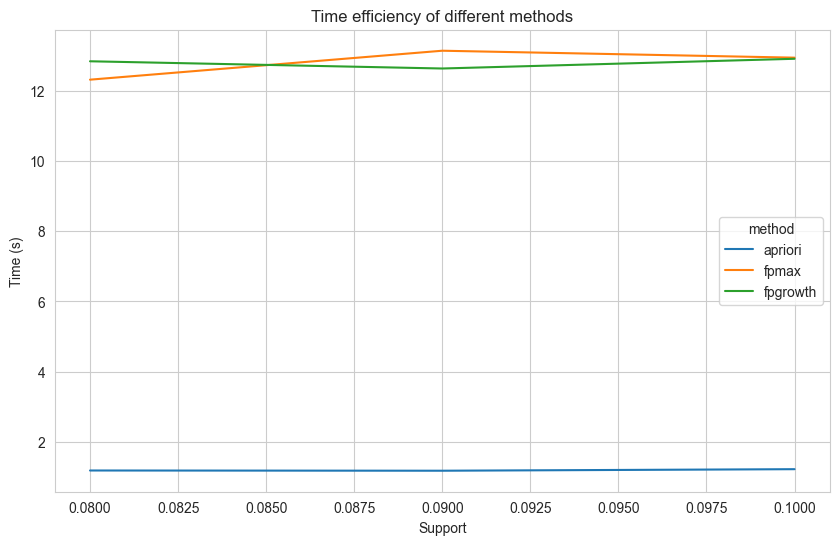

In [46]:
# Plot of how time efficient the different methods are
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(x='support', y='time', hue='method', data=results_df)
plt.title('Time efficiency of different methods')
plt.xlabel('Support')
plt.ylabel('Time (s)')
plt.savefig('time_efficiency.png')
plt.show()

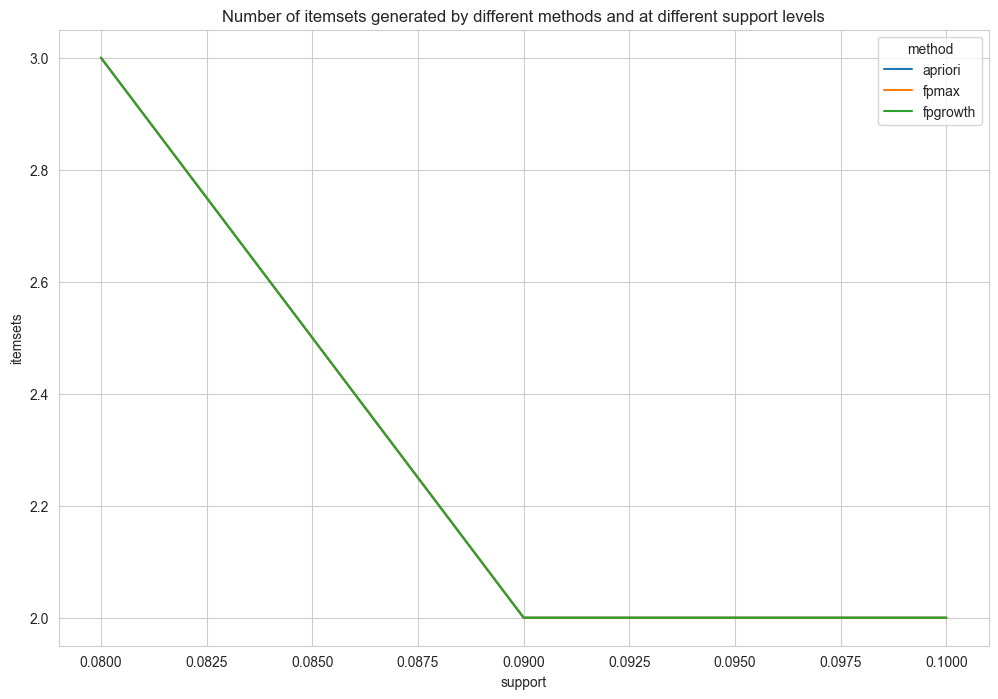

In [48]:
# Plot how many rules are generated by the different methods
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.lineplot(x='support', y='itemsets', hue='method', data=results_df)
plt.title('Number of itemsets generated by different methods and at different support levels')
plt.show()


Summary here of the results: # need to run the function with the full list of support values to get the results. 

Most efficient mode: I am guessing we should use apriori but need to run the final version of the code
Most efficient support: Need to run the final version of the code